In [2]:
!pip install Celluloid

In [3]:
import torch
import torch.distributions as D
import numpy as np

import sw

from torch.distributions.multivariate_normal import MultivariateNormal
from scipy.linalg import expm
from scipy.stats import gaussian_kde
from sklearn.datasets import make_spd_matrix
from mpl_toolkits import mplot3d
from celluloid import Camera
from IPython.display import HTML

from swgf import SWGF
from utils_2d import *

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Sliced-Wasserstein Gradient Flows on Particles

### Aggregation Equation

https://arxiv.org/pdf/1901.08081.pdf p 34

\begin{equation*}
    W(x)=\frac{\|x\|^4}{4} - \frac{\|x\|^2}{2}
\end{equation*}

(convention $\frac{\|x\|^0}{0}=\log\|x\|$)

In [5]:
def W(x):
    norm_x = torch.linalg.norm(x, dim=-1)
    # return norm_x**2/2 - torch.log(norm_x)
    return norm_x**4/4 - norm_x**2/2

def J(x):
    ws = W(x-x[:,None])
    w = torch.mean(ws)
    return w/2  

In [6]:
t_init = 0
t_end = 10
h = 0.05

n = 1000

d = 2
mu0 = torch.tensor(np.array([0,0]),device=device,dtype=torch.float)
sigma0 = torch.tensor(0.25**2 * np.eye(2),device=device,dtype=torch.float)

normal = MultivariateNormal(mu0,sigma0)
x0 = normal.sample((n,))

print(x0.shape)

Lx = SWGF(x0, h, n_step=np.int(np.ceil((t_end-t_init)/h)), n_epochs=500,
          J=J, emd1D=sw.emd1D, sliced_wasserstein=sw.sliced_wasserstein,
          lr=1, num_projections=1000, device=device, plot_train=False,
          plot=False)

torch.Size([1000, 2])


  0%|          | 0/200 [00:00<?, ?it/s]

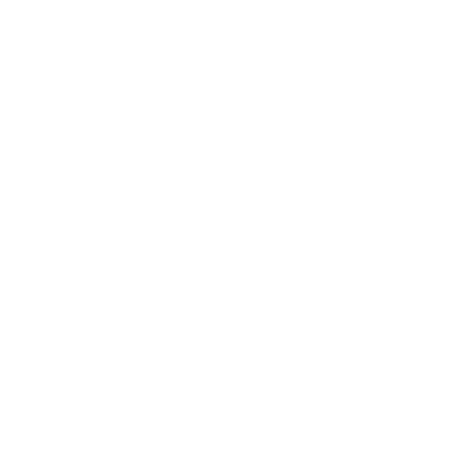

In [7]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
camera = Camera(fig)
for x in Lx:
  ax.scatter(x[:,0].detach().cpu(), x[:,1].detach().cpu(), c="black")
  ax.axis('off')
  camera.snap()

animation = camera.animate()

In [8]:
HTML(animation.to_html5_video())

In [ ]:
kernel = gaussian_kde(x.T.detach().cpu())

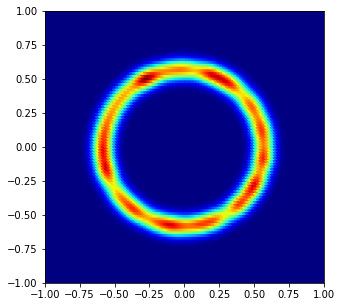

In [ ]:
h = 0.125
kernel.set_bandwidth(h)

xmin, xmax, ymin, ymax = -1, 1, -1, 1

xline = np.linspace(xmin, xmax, 100)
yline = np.linspace(ymin, ymax, 100)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)],axis=1)

zz = kernel.pdf(xyinput.T)
zgrid = zz.reshape(100, 100)

plt.figure(figsize=(5,5))
plt.scatter(xyinput[:,0], xyinput[:,1], c=zz, cmap="jet")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# plt.title(h)
plt.show()

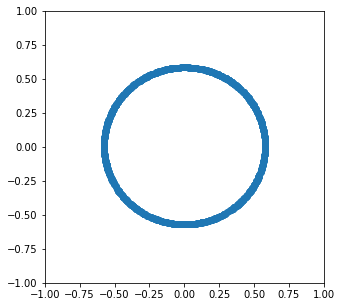

In [ ]:
plt.figure(figsize=(5,5))

plt.scatter(x[:,0].detach().cpu(), x[:,1].detach().cpu())
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

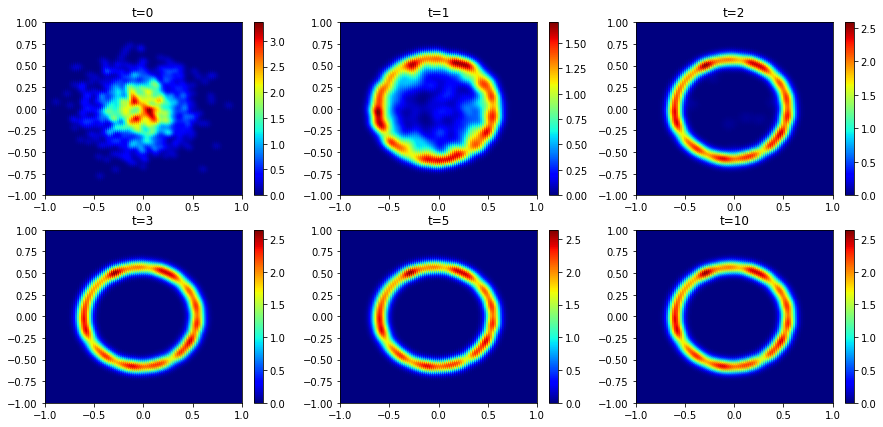

In [ ]:
ts=[0,1,2,3,5,10]
fig, ax = plt.subplots(2,3,figsize=(15,7))

xline = torch.linspace(xmin, xmax, 100)
yline = torch.linspace(ymin, ymax, 100)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

for ind,t in enumerate(ts):
    i = ind//3
    j = ind%3

    k = int(t*(len(Lx)-1)/t_end)

    kernel = gaussian_kde(Lx[k].T.detach().cpu())
    kernel.set_bandwidth(0.125)

    zz = kernel.pdf(xyinput.T)
    zgrid = zz.reshape(100, 100)

    cb = ax[i,j].scatter(xgrid, ygrid, c=zgrid,cmap="jet")
    fig.colorbar(cb, ax=ax[i,j])
    ax[i,j].set_title("t="+str(t))
    ax[i,j].set_xlim(xmin, xmax)
    ax[i,j].set_ylim(ymin, ymax)

plt.show()

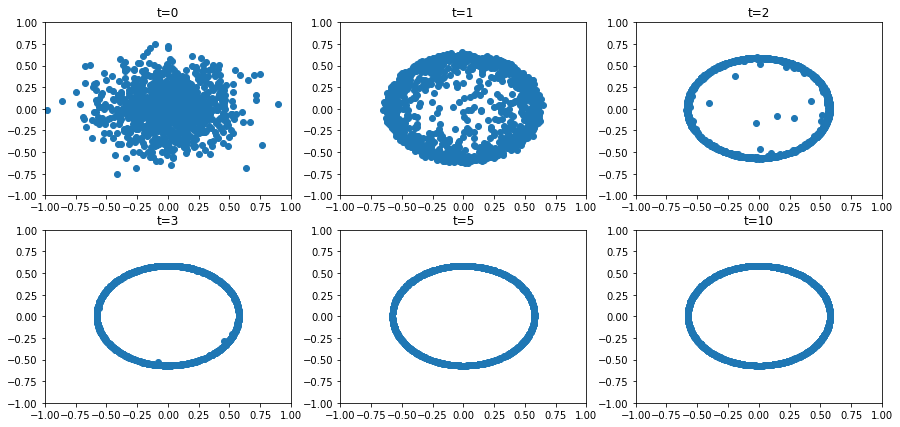

In [ ]:
ts=[0,1,2,3,5,10]
fig, ax = plt.subplots(2,3,figsize=(15,7))

xline = torch.linspace(xmin, xmax, 100)
yline = torch.linspace(ymin, ymax, 100)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

for ind,t in enumerate(ts):
    i = ind//3
    j = ind%3

    k = int(t*(len(Lx)-1)/t_end)

    ax[i,j].scatter(Lx[k].detach().cpu()[:,0], Lx[k].detach().cpu()[:,1])
    # fig.colorbar(cb, ax=ax[i,j])
    ax[i,j].set_title("t="+str(t))
    ax[i,j].set_xlim(xmin, xmax)
    ax[i,j].set_ylim(ymin, ymax)

plt.show()

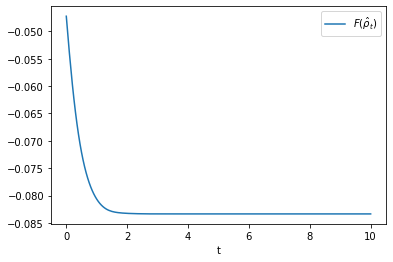

In [ ]:
def plot_F(F, Lx, device, d=2, t_init=0, t_end=4):
    L = []

    for i in range(len(Lx)):
        L.append(F(Lx[i]))

    absc = np.linspace(t_init, t_end, len(L))
    plt.plot(absc, L, label=r"$F(\hat{\rho}_t)$")
    plt.xlabel("t")
    plt.legend()
    plt.show()

plot_F(J, Lx, device,t_end=10)

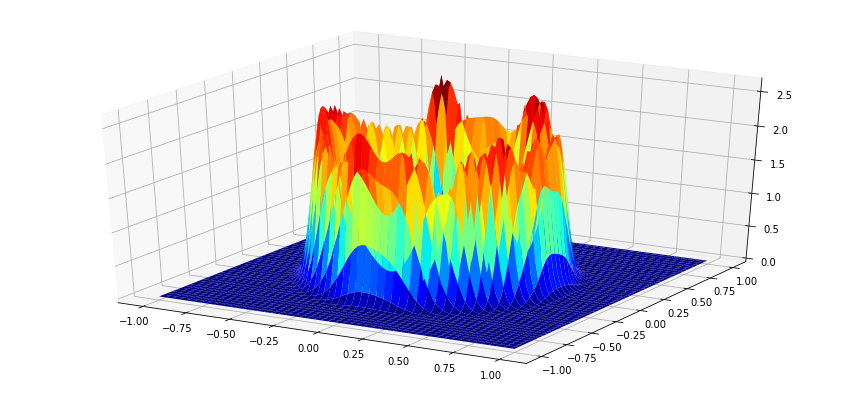

In [ ]:
fig = plt.figure(figsize=(15,7))

kernel = gaussian_kde(Lx[-1].T.detach().cpu())
kernel.set_bandwidth(0.125)

xline = np.linspace(xmin, xmax, 100)
yline = np.linspace(ymin, ymax, 100)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)],axis=1)

zz = kernel.pdf(xyinput.T)

ax = fig.add_subplot(1,1,1,projection="3d")
ax.plot_surface(xgrid, ygrid, zz.reshape(100,100), cmap="jet") #, c=zz)
# ax.view_init(elev=0) #, azim=260)
plt.show()

### Fokker-Planck with Gaussians

We focus on the Fokker-Planck PDE:

**Fokker-Planck Equation**:
- PDE:
\begin{equation}
    \frac{\partial\rho}{\partial t} = \mathrm{div}(\rho\nabla V)+\Delta \rho
\end{equation}
- Associated SDE:
\begin{equation*}
    \mathrm{d}x_t = \nabla V(x)\mathrm{d}t+\sqrt{2}\mathrm{d}w_t
\end{equation*}


**JKO Scheme in SW Space**:

We want to solve at each step:

\begin{equation*}
    \rho_{k+1}^\tau = \mathrm{argmin}_{\rho\in\Sigma_n}\ \frac{1}{2\tau}SW_2^2(\rho,\rho_k^\tau) + J(\rho)
\end{equation*}
with 
\begin{equation}
    \begin{aligned}
        J(\rho) &= \int V(x)\rho(x)\mathrm{d}x + \int \log(\rho(x))\rho(x)\mathrm{d}x \\
        &\approx \frac{1}{n}\sum_{i=1}^n V(x_i) + \frac{1}{n}\sum_{i=1}^n \log(f_n^h(x_i))
    \end{aligned}
\end{equation}
where $f_n$ represents a kernel density estimate (see e.g. https://www.researchgate.net/publication/243768404_Nonparametric_Entropy_Estimation_An_Overview).

\begin{equation*}
    \mathrm{d}X_t = -AX_t\mathrm{d}t+\sqrt{2}\mathrm{d}W_t
\end{equation*}
Here, $V(x)=\frac12 X^T A X$.
We will take $A=I$ and initialize with $\rho_0=\mathcal{N}(\mu_0,\Sigma_0)$ and $\mu_0=\begin{pmatrix}2 \\ 2 \end{pmatrix}$, $\Sigma_0 = 4 I_2$.

The analytical pdf at each time $t$ is $\mathcal{N}\Big(\exp(-At)\mu_0,(\Sigma_0-A^{-1})\exp(-2At)+A^{-1}\Big)$.

#### Easy Gaussian

In [ ]:
A = torch.tensor(np.eye(2),dtype=torch.float).to(device)
# V = lambda x : x.T@(A@x)/2

mu0 = torch.tensor(np.array([2,2]),device=device,dtype=torch.float)
sigma0 = torch.tensor(4*np.eye(2),device=device,dtype=torch.float)

A2 = A.detach().cpu().numpy()
mu02 = mu0.detach().cpu().numpy()
sigma02 = sigma0.detach().cpu().numpy()
A2_ = np.linalg.inv(A2)

def true_mu(t):
    B = expm(-A2*t)
    return B@mu02

def true_Sigma(t):
    e = expm(-2*A2*t)
    s = (sigma02-A2_)@e+A2_
    return s

mu_stationary = np.zeros(2)
sigma_stationary = A2

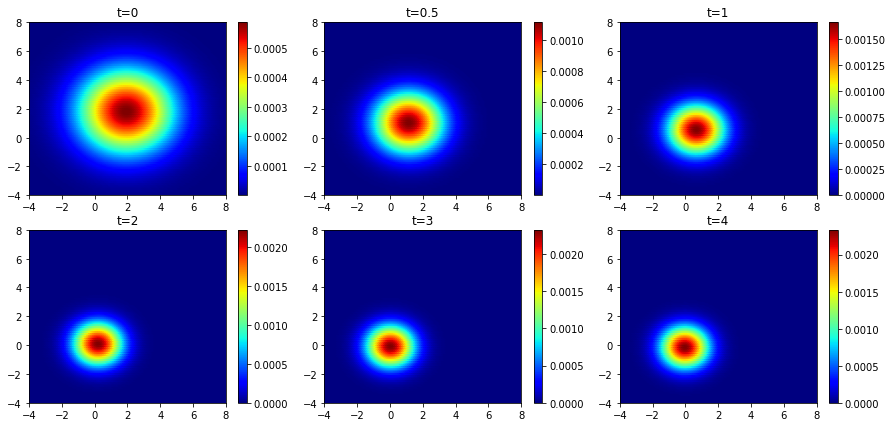

In [ ]:
x_min = -4
x_max = 8
n_samples = 100

x = np.linspace(x_min,x_max,n_samples)
y = np.linspace(x_min,x_max,n_samples)
xx, yy = np.meshgrid(x,y)

grid = np.concatenate([xx.flatten()[None,:].T,yy.flatten()[None,:].T], axis=1)

plot_true_density(grid, true_mu, true_Sigma)

In [ ]:
def kernel(xs, t, h):
    x = (xs[:,None,:]-t)/h
    return torch.prod(torch.exp(-x**2/2)/(h*np.sqrt(2*np.pi)),axis=-1)


def H(x, h=1/2):
    """
        kernel estimator
    """
    n, d = x.size()
    K = kernel(x, x, h)
    density = torch.mean(K, axis=0)
    return torch.mean(torch.log(density), axis=0)

def V(x):
    x = x[:,:,None]   
    y = torch.matmul(A,x)
    z = torch.matmul(torch.transpose(x,1,2),y)
    return z[:,0,0]/2  

def J(x):
    return torch.mean(V(x))+H(x)

In [ ]:
t_init = 0
t_end = 4
h = 0.1

n = 1000

d = 2
# mu0 = torch.tensor(np.array([0,0]),device=device,dtype=torch.float)
# sigma0 = torch.tensor(0.25**2 * np.eye(2),device=device,dtype=torch.float)

mu0 = torch.tensor(np.array([2,2]),device=device,dtype=torch.float)
sigma0 = torch.tensor(4*np.eye(2),device=device,dtype=torch.float)

normal = MultivariateNormal(mu0,sigma0)
x0 = normal.sample((n,))

print(x0.shape)

Lx = SWGF(x0, h, n_step=np.int(np.ceil((t_end-t_init)/h)), n_epochs=500,
          J=J, emd1D=sw.emd1D, sliced_wasserstein=sw.sliced_wasserstein,
          lr=1, num_projections=1000, device=device, plot_train=False,
          plot=False)

torch.Size([1000, 2])


  0%|          | 0/40 [00:00<?, ?it/s]

torch.Size([1000, 2])


  0%|          | 0/40 [00:00<?, ?it/s]

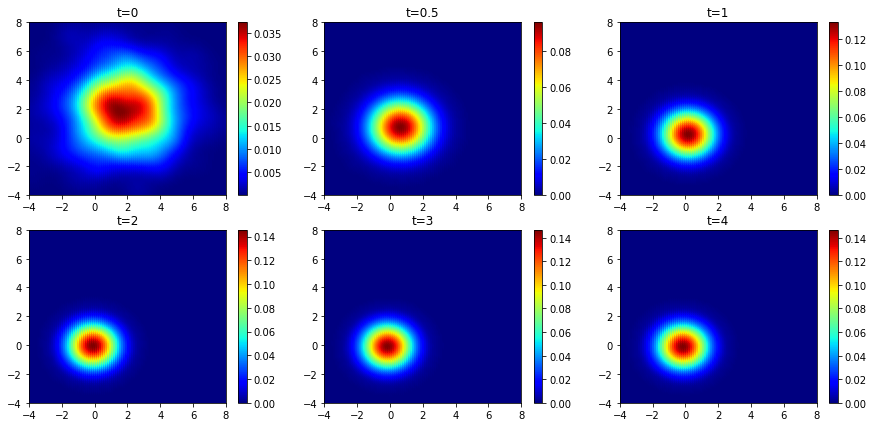

In [ ]:
ts=[0,0.5,1,2,3,4]
fig, ax = plt.subplots(2,3,figsize=(15,7))

xmin, xmax, ymin, ymax = -4, 8, -4, 8

xline = torch.linspace(xmin, xmax, 100)
yline = torch.linspace(ymin, ymax, 100)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

for ind,t in enumerate(ts):
    i = ind//3
    j = ind%3

    k = int(t*(len(Lx)-1)/t_end)

    kernel_g = gaussian_kde(Lx[k].T.detach().cpu())
    # kernel.set_bandwidth(0.125)

    zz = kernel_g.pdf(xyinput.T)
    zgrid = zz.reshape(100, 100)

    cb = ax[i,j].scatter(xgrid, ygrid, c=zgrid,cmap="jet")
    fig.colorbar(cb, ax=ax[i,j])
    ax[i,j].set_title("t="+str(t))
    ax[i,j].set_xlim(xmin, xmax)
    ax[i,j].set_ylim(ymin, ymax)

plt.show()

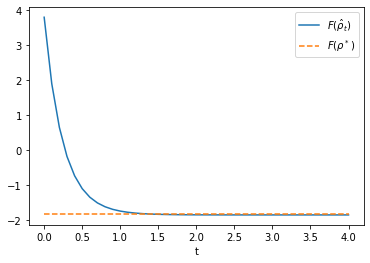

In [ ]:
def plot_F(F, Lx, device, d=2, t_init=0, t_end=4, distr_stationary=None):
    L = []

    for i in range(len(Lx)):
        L.append(F(Lx[i]))

    if distr_stationary is not None:
        x_s = distr_stationary.sample((n_samples,))
        log_prob_xs = distr_stationary.log_prob(x_s)
        F_stationary = torch.mean(V(x_s), axis=0)+torch.mean(log_prob_xs, axis=0)
        F_stationary = F_stationary.detach().cpu().numpy()

    absc = np.linspace(t_init, t_end, len(L))
    plt.plot(absc, L, label=r"$F(\hat{\rho}_t)$")
    if distr_stationary is not None:
        plt.plot(absc, F_stationary*np.ones(len(absc)), '--', label=r"$F(\rho^*)$")

    plt.xlabel("t")
    plt.legend()
    plt.show()

distr_stationary = D.MultivariateNormal(torch.tensor(mu_stationary, dtype=torch.float, device=device),
                                       torch.tensor(sigma_stationary, dtype=torch.float, device=device))

plot_F(J, Lx, device, t_end=4, distr_stationary=distr_stationary)

In [ ]:
def plot_F_gaussians(F, Lx, true_mu, true_sigma, mu_stationary, 
                     sigma_stationary, V, device, t0=0, t1=4,dilation=1,
                     n_samples=10000):
    L = []
    L_true = []
    
    absc = np.linspace(t0, t1, len(Lx))
    
    for i in range(len(Lx)):
        L.append(F(Lx[i]))
        
        t = absc[i]*dilation
        
        mu_t = true_mu(t)
        Sigma_t = true_sigma(t)
        x_t = multivariate_normal.rvs(mu_t, Sigma_t, n_samples)
        log_prob = multivariate_normal.logpdf(x_t, mu_t, Sigma_t)
        x_t = torch.tensor(x_t, device=device, dtype=torch.float)
        log_prob = torch.tensor(log_prob, device=device, dtype=torch.float)
        L_true.append(torch.mean(V(x_t), axis=0)+torch.mean(log_prob, axis=0))
        
    x_s = multivariate_normal.rvs(mu_stationary, sigma_stationary, n_samples)
    log_prob_s = multivariate_normal.logpdf(x_s, mu_stationary, sigma_stationary)
    x_s = torch.tensor(x_s, device=device, dtype=torch.float)
    log_prob_s = torch.tensor(log_prob_s, device=device, dtype=torch.float)
    F_stationary = torch.mean(V(x_s), axis=0)+torch.mean(log_prob_s, axis=0)        
        
    if dilation!=1:
        plt.plot(absc, L_true, label=r"$F(\rho_{"+str(dilation)+r"t})$")
    else:
        plt.plot(absc, L_true, label=r"$F(\rho_t)$")
        
    plt.plot(absc, L, label=r"$F(\hat{\rho}_{t})$")
        
    plt.plot(absc, np.ones(len(absc))*F_stationary.cpu().numpy(), '--', label=r"$F(\rho^*)$")
    plt.xlabel("t")
    plt.legend()
    plt.show()

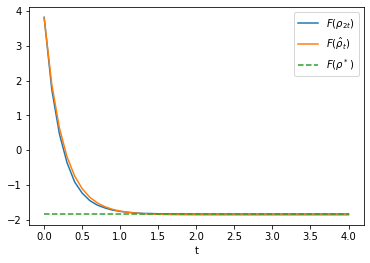

In [ ]:
plot_F_gaussians(J, Lx, true_mu, true_Sigma, mu_stationary, sigma_stationary,
                 V, device, dilation=d)

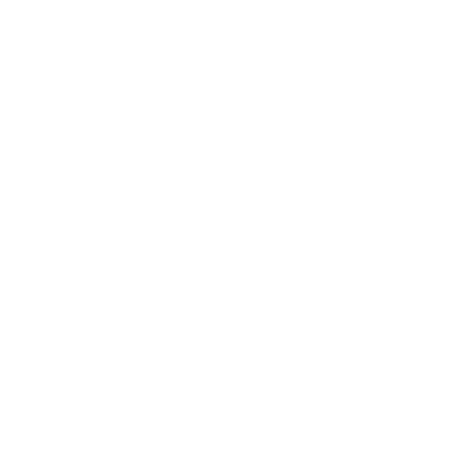

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
camera = Camera(fig)
for x in Lx:
  ax.scatter(x[:,0].detach().cpu(), x[:,1].detach().cpu(), c="black")
  ax.axis('off')
  camera.snap()

animation = camera.animate()

In [ ]:
HTML(animation.to_html5_video())

### Gaussian Mixture

In [ ]:
random_state = 42
torch.manual_seed(random_state)

d = 2
M = 5
l = 10

p = torch.ones(M)/M
mus = -l/2 + l * torch.rand((M,d), device=device) #, dtype=torch.float64)
sigmas = [torch.eye(d, device=device, dtype=torch.float32) for i in range(M)]

mix = D.Categorical(p.to(device))
comp = D.Independent(D.Normal(mus,torch.ones(M,d,device=device)),1)

gm = D.MixtureSameFamily(mix, comp)

def V(x):
    dists = -torch.square(torch.cdist(mus,x))/2
    return -torch.logsumexp(dists,0)

mu0 = torch.tensor(np.array([0,0]),device=device,dtype=torch.float)
sigma0 = 16*torch.tensor(np.eye(2),device=device,dtype=torch.float)

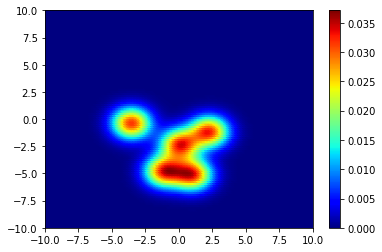

In [ ]:
xmin, xmax, ymin, ymax = -10,10,-10,10

xline = np.linspace(xmin, xmax, 100)
yline = np.linspace(ymin, ymax, 100)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)],axis=1)

zz = gm.log_prob(torch.tensor(xyinput, dtype=torch.float32, device=device)).exp().detach().cpu()
zgrid = zz.reshape(100,100)

plt.scatter(xyinput[:,0], xyinput[:,1], c=zz, cmap="jet")
plt.colorbar()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.show()

#### SW

In [ ]:
t_init = 0
t_end = 4
h = 0.1

n = 1000

d = 2

normal = MultivariateNormal(mu0,sigma0)
x0 = normal.sample((n,))

print(x0.shape)

Lx = SWGF(x0, h, n_step=np.int(np.ceil((t_end-t_init)/h)), n_epochs=500,
          J=J, emd1D=sw.emd1D, sliced_wasserstein=sw.sliced_wasserstein,
          lr=1, num_projections=1000, device=device, plot_train=False,
          plot=False)

torch.Size([1000, 2])


  0%|          | 0/40 [00:00<?, ?it/s]

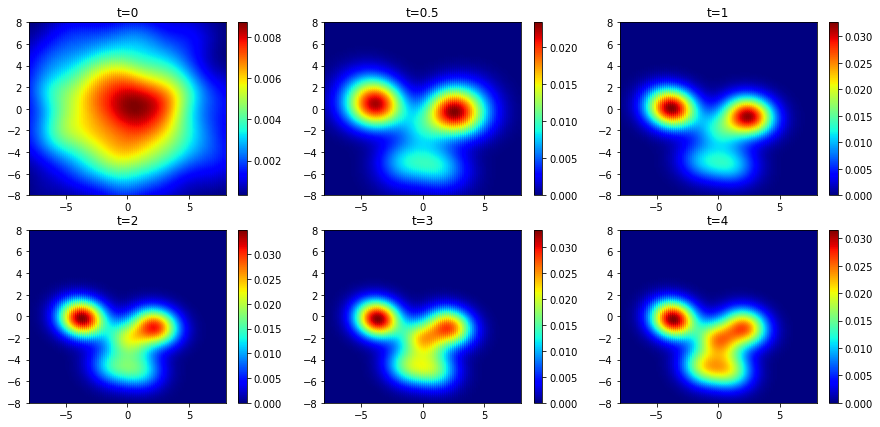

In [ ]:
ts=[0,0.5,1,2,3,4]
fig, ax = plt.subplots(2,3,figsize=(15,7))

xmin, xmax, ymin, ymax = -8, 8, -8, 8

xline = torch.linspace(xmin, xmax, 100)
yline = torch.linspace(ymin, ymax, 100)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

for ind,t in enumerate(ts):
    i = ind//3
    j = ind%3

    k = int(t*(len(Lx)-1)/t_end)

    kernel_g = gaussian_kde(Lx[k].T.detach().cpu())
    # kernel.set_bandwidth(0.125)

    zz = kernel_g.pdf(xyinput.T)
    zgrid = zz.reshape(100, 100)

    cb = ax[i,j].scatter(xgrid, ygrid, c=zgrid,cmap="jet")
    fig.colorbar(cb, ax=ax[i,j])
    ax[i,j].set_title("t="+str(t))
    ax[i,j].set_xlim(xmin, xmax)
    ax[i,j].set_ylim(ymin, ymax)

plt.show()

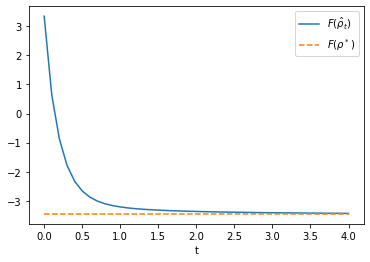

In [ ]:
plot_F(J, Lx, device, t_end=4, distr_stationary=gm)

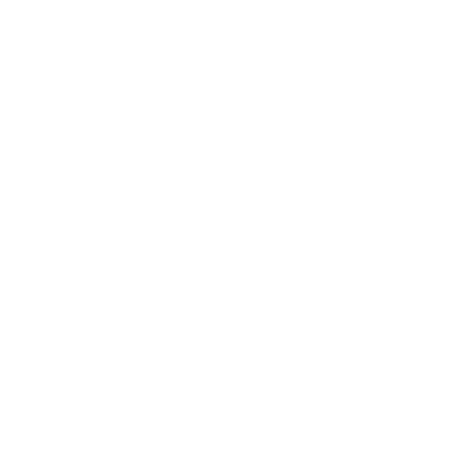

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
camera = Camera(fig)
for x in Lx:
  ax.scatter(x[:,0].detach().cpu(), x[:,1].detach().cpu(), c="black")
  ax.axis('off')
  camera.snap()

animation = camera.animate()

In [ ]:
from IPython.display import HTML
HTML(animation.to_html5_video())